# Sistema de Recomendacao de Jogos
## Carregamento de dados

In [ ]:
import pandas as pd
df = pd.read_json('.../Projeto_Aplicado_III/australian_users_items_fixed.json')

## Pre-processamento de Dados

In [4]:
df = df.explode('items').reset_index(drop=True)
items = df["items"].tolist()
df.drop(columns=['items'], inplace = True)
items = [item  if type(item) == dict else {} for item in items] 
items_df = pd.DataFrame(items)
items_df.drop(columns=['playtime_2weeks', 'item_id'], inplace = True)
items_df.head()

,item_name,playtime_forever
0,Counter-Strike,6.0
1,Team Fortress Classic,0.0
2,Day of Defeat,7.0
3,Deathmatch Classic,0.0
4,Half-Life: Opposing Force,0.0


In [5]:
df_user = df["user_id"]
df_final = pd.concat([df_user, items_df], axis=1)
df_final.dropna()
df_final.head()

,user_id,item_name,playtime_forever
0,76561197970982479,Counter-Strike,6.0
1,76561197970982479,Team Fortress Classic,0.0
2,76561197970982479,Day of Defeat,7.0
3,76561197970982479,Deathmatch Classic,0.0
4,76561197970982479,Half-Life: Opposing Force,0.0


## Transformacao de dados 

In [16]:
import numpy as np
import matplotlib.pyplot as plt

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

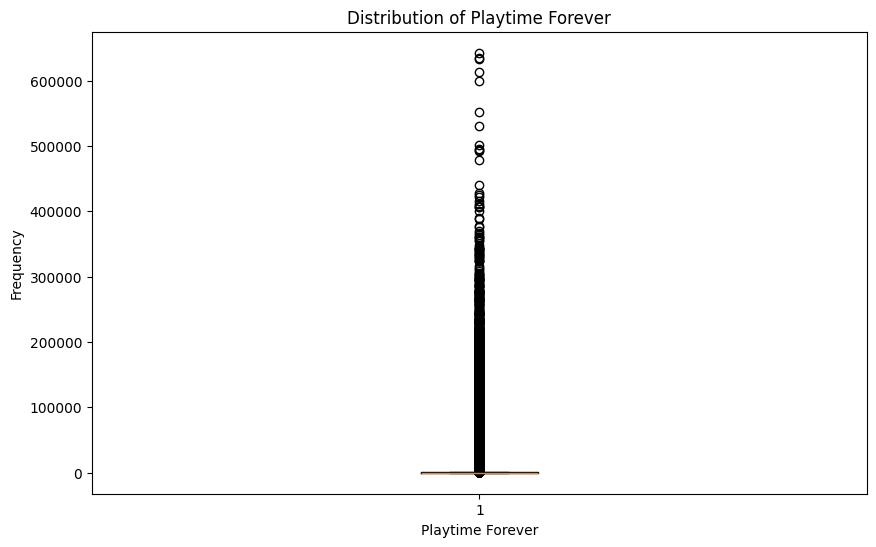

In [48]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_final['playtime_forever'])
plt.xlabel('Playtime Forever')
plt.ylabel('Frequency')
plt.title('Distribution of Playtime Forever')
plt.show()

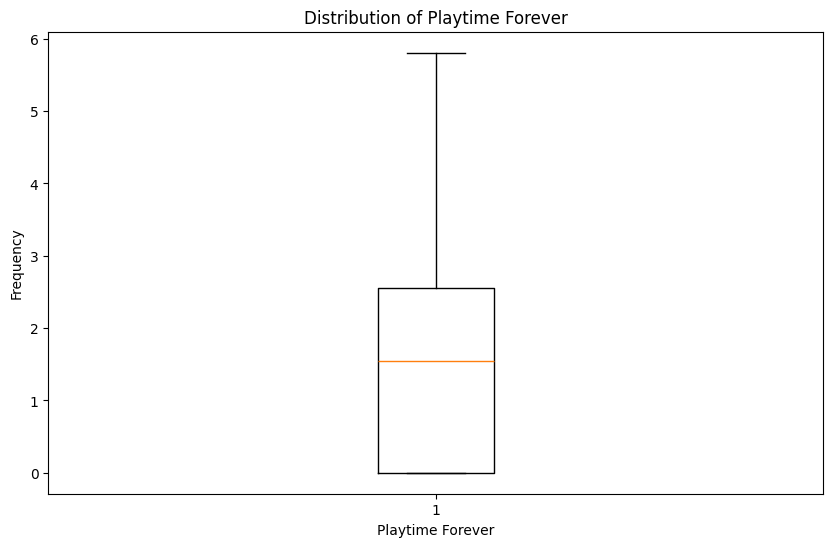

In [49]:
df_final['log_playtime_forever'] = np.log10(df_final['playtime_forever']+1)

plt.figure(figsize=(10, 6))
plt.boxplot(df_final['log_playtime_forever'])
plt.xlabel('Playtime Forever')
plt.ylabel('Frequency')
plt.title('Distribution of Playtime Forever')
plt.show()

## Train-Test Split

### Removendo usuarios que jogaram poucos jogos

In [34]:
df_final.shape

(5170015, 4)

In [35]:
df_count = df_final.groupby('user_id')['item_name'].count()
df_count.head()

user_id
--000--               58
--ace--               44
--ionex--             23
-2SV-vuLB-Kg          68
-404PageNotFound-    149
Name: item_name, dtype: int64

In [36]:
len(df_final['user_id'].unique())

87626

In [37]:
df_count[df_count<=1].count()

np.int64(20016)

In [38]:
removed_users = df_count[df_count<=1].index

In [39]:
len(removed_users)

20016

In [40]:
df_final.shape

(5170015, 4)

In [41]:
df_final = df_final[~df_final['user_id'].isin(list(removed_users))]

In [42]:
df_final.shape

(5149907, 4)

### Separando em treinamento e teste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Listas para armazenar os dados de treino e teste
train_list = []
test_list = []

# Itera sobre cada grupo de user_id
for user_id, user_data in df_final.groupby('user_id'):
    if len(user_data) > 1:
        # Divide os dados do usuário em 80% treino e 20% teste
        user_train, user_test = train_test_split(user_data, test_size=0.2, random_state=42)
    else:
        continue
    
    train_list.append(user_train)
    test_list.append(user_test)

# Concatena todos os dados de treino e teste
train_data = pd.concat(train_list)
test_data = pd.concat(test_list)

In [55]:
len(train_data['user_id'].unique())

67610

In [56]:
len(test_data['user_id'].unique())

67610

## Modelo de Correlação

In [18]:
len(df_final['item_name'].unique())

10947

In [19]:
train_data.head()

,user_id,item_name,playtime_forever,log_playtime_forever
1810605,--000--,Trove,4260.0,3.629512
1810600,--000--,Guns and Robots,0.0,0.000000
1810577,--000--,Hero Academy,38.0,1.591065
1810586,--000--,Path of Exile,89.0,1.954243
1810575,--000--,Terraria,1172.0,3.069298


In [20]:
pivot_table = train_data.pivot_table(columns='item_name', index='user_id', values='log_playtime_forever', fill_value=0)

In [21]:
correlation_matrix = pivot_table.corr()

In [24]:
correlation_matrix

item_name,神明的一天世界(God's One Day World),! That Bastard Is Trying To Steal Our Gold !,"""Glow Ball"" - The billiard puzzle game",#SelfieTennis,#killallzombies,$1 Ride,'n Verlore Verstand,.EXE,001 Game Creator,007™ Legends,...,theBlu,theHunter,theHunter: Primal,vrAMP,Безумный Макс: Дорога ярости,丛林守望者（Ranger of the jungle）,侠客风云传(Tale of Wuxia),大海战 Navy Field IV,神楽道中記(KaguraDouchuuki),軒轅劍外傳穹之扉(The Gate of Firmament)
item_name,,,,,,,,,,,,,,,,,,,,,
神明的一天世界(God's One Day World),1.000000,-0.000021,-0.000040,-0.000046,-0.000030,0.262080,-0.000021,NaN,-0.000030,-0.000072,...,-0.000110,-0.001228,-0.000304,-0.000028,NaN,-0.000021,-0.000058,-0.000026,-0.000021,-0.000049
! That Bastard Is Trying To Steal Our Gold !,-0.000021,1.000000,-0.000028,-0.000032,-0.000021,-0.000039,-0.000015,NaN,-0.000021,-0.000051,...,-0.000078,-0.000870,-0.000215,-0.000020,NaN,-0.000015,-0.000041,-0.000019,-0.000015,-0.000035
"""Glow Ball"" - The billiard puzzle game",-0.000040,-0.000028,1.000000,-0.000062,-0.000040,-0.000075,-0.000028,NaN,-0.000040,-0.000098,...,-0.000149,0.009445,-0.000414,-0.000038,NaN,-0.000028,-0.000079,-0.000036,-0.000028,-0.000067
#SelfieTennis,-0.000046,-0.000032,-0.000062,1.000000,-0.000046,-0.000085,-0.000032,NaN,-0.000046,-0.000111,...,0.118427,0.005349,-0.000469,-0.000043,NaN,-0.000032,-0.000090,-0.000041,-0.000032,-0.000076
#killallzombies,-0.000030,-0.000021,-0.000040,-0.000046,1.000000,0.259650,-0.000021,NaN,-0.000030,0.101250,...,-0.000110,-0.001228,0.023669,-0.000028,NaN,-0.000021,-0.000058,0.659089,-0.000021,-0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
丛林守望者（Ranger of the jungle）,-0.000021,-0.000015,-0.000028,-0.000032,-0.000021,-0.000039,-0.000015,NaN,-0.000021,-0.000051,...,-0.000078,-0.000870,-0.000215,-0.000020,NaN,1.000000,0.390247,-0.000019,1.000000,0.497016
侠客风云传(Tale of Wuxia),-0.000058,-0.000041,-0.000079,-0.000090,-0.000058,-0.000109,-0.000041,NaN,-0.000058,-0.000142,...,-0.000216,-0.002421,-0.000599,-0.000055,NaN,0.390247,1.000000,-0.000052,0.390247,0.193893
大海战 Navy Field IV,-0.000026,-0.000019,-0.000036,-0.000041,0.659089,0.378382,-0.000019,NaN,-0.000026,0.147578,...,-0.000098,0.000790,0.034661,-0.000025,NaN,-0.000019,-0.000052,1.000000,-0.000019,-0.000044


In [217]:
def user_recomendations(user_id, dataframe):
    correlations = []
    top_5_games = dataframe[dataframe['user_id'] == user_id].nlargest(5, 'playtime_forever')[['item_name']]
    top_5_games = top_5_games['item_name'].tolist()
    top_5_correlations = correlation_matrix[top_5_games].drop(top_5_games)
    for game in top_5_correlations.columns:
        top_5_correlations = correlation_matrix[game].drop(game).nlargest(2)
        top_values = top_5_correlations.reset_index().rename(columns={game: 'value'})
        top_values['user_id'] = user_id
        correlations.append(top_values)

    correlations_df = pd.concat(correlations, axis=0)
    return correlations_df

In [218]:
user_recomendations('--000--', train_data)

,item_name,value,user_id
0,PAYDAY 2,0.230286,--000--
1,Rust,0.211344,--000--
0,Unturned,0.267594,--000--
1,Brawlhalla,0.245879,--000--
0,Robocraft,0.281113,--000--
1,Trove,0.267594,--000--
0,Killing Floor 2,0.326063,--000--
1,Killing Floor Mod: Defence Alliance 2,0.325921,--000--
0,Saints Row IV,0.339459,--000--
1,Saints Row 2,0.263086,--000--


In [219]:
users = train_data['user_id'].unique()

In [231]:
all_recomendations = []
for user in users:
    recomendations = user_recomendations(user, train_data)
    all_recomendations.append(recomendations)

In [232]:
all_recomendations = pd.concat(all_recomendations, axis=0)

In [233]:
matches = pd.merge(all_recomendations, test_data, on=['user_id', 'item_name'])
accuracy = len(matches)/len(all_recomendations)

In [235]:
accuracy *100

10.073014964021612

In [238]:
len(matches['user_id'].unique())/len(users)

0.5793817482620914